In [2]:
import numpy as np

from scipy.stats import uniform, randint

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [3]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [4]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# E-Jeep Data Set

In [34]:
import csv 
import pandas as pd

# convert to array
with open('../E-Jeep Data/Ejeep Sept 18.csv', 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    data = list(csv_reader)
    
# get track data and remove waypoints
for i,row in enumerate(data):
    if(len(row) > 0 and row[0] == 'Track'):
        data = data[i+1:]
        break

# remove header
header = data[0]
data = data[1:]

# convert to float and breakdown time data
for i in range(len(data)):
    data[i][3] = float(data[i][3])
    data[i][4] = float(data[i][4])
    
    # print(data[i]+data[i][1].replace('/', ' ').replace(':', ' ').replace('-', ' ').replace('.', ' ').split())
    
    # hack to get individual time data
    timelog = [int(x) for x in data[i][1].replace('/', ' ').replace(':', ' ').replace('-', ' ').replace('.', ' ').split()]
    data[i] += timelog

header += ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'Millisecond']   

# convert to dataframe
df = pd.DataFrame(data, columns=header)

df.head(10)

,Date(GMT),Date(Local),Time(sec),Latitude,Longitude,Horizontal Accuracy(m),Altitude(m),Vertical Accuracy(m),Distance(m),Speed(m/s),...,Heading Accuracy(deg),Glide Ratio,Heart Rate (bpm),Year,Month,Day,Hour,Minute,Second,Millisecond
0,2023-09-18 04:52:44.00,2023-09-18 12:52:44.00,0.0003160238265991211,14.634736,121.076293,3.535533905932737,60.64281845092773,3,0,0,...,11.94986534118652,1018.12073776826,0,2023,9,18,12,52,44,0
1,2023-09-18 04:52:45.00,2023-09-18 12:52:45.00,0.5302410125732422,14.634736,121.076293,4.612905477116144,60.64281840994954,3.541982508706206,0,0,...,11.94986534118652,296.1881525974027,0,2023,9,18,12,52,45,0
2,2023-09-18 04:52:46.00,2023-09-18 12:52:46.00,1.522344946861267,14.634737,121.076293,4.612905477623176,61.00182719901204,3.541982508045873,0.04856229260522659,0,...,11.94986534118652,-171.6421289682452,0,2023,9,18,12,52,46,0
3,2023-09-18 04:52:47.00,2023-09-18 12:52:47.00,2.522934913635254,14.634726,121.076292,4.612905509348495,60.74187846761197,3.541982466728363,1.215731137435719,0,...,11.94986534118652,12.49411691942023,0,2023,9,18,12,52,47,0
4,2023-09-18 04:52:48.00,2023-09-18 12:52:48.00,3.522957921028137,14.634731,121.076293,4.612905492281161,61.36095805745572,3.541982488956028,1.796300261823075,0,...,11.91374492645264,3.42105642573424,0,2023,9,18,12,52,48,0
5,2023-09-18 04:52:49.00,2023-09-18 12:52:49.00,4.522933006286621,14.634732,121.076295,4.612905484480541,61.51488872151822,3.541982499115176,2.005280110045816,0,...,11.91004085540771,1.07442003648176,0,2023,9,18,12,52,49,0
6,2023-09-18 04:52:50.00,2023-09-18 12:52:50.00,5.522817015647888,14.634723,121.076296,4.612905503255921,61.07604594808072,3.541982474663035,2.980479474989021,0,...,11.91004085540771,1.310678106902141,0,2023,9,18,12,52,50,0
7,2023-09-18 04:52:51.00,2023-09-18 12:52:51.00,6.522790908813477,14.634720,121.076298,4.612905504615512,61.28716655354947,3.54198247289237,3.372537853205944,0,...,11.90593814849854,1.197349547133804,0,2023,9,18,12,52,51,0
8,2023-09-18 04:52:52.00,2023-09-18 12:52:52.00,7.522742986679077,14.634720,121.076298,4.612905502314121,61.66930766776204,3.54198247588959,3.457050379974796,0,...,11.90456295013428,1.401959559558112,0,2023,9,18,12,52,52,0
9,2023-09-18 04:52:53.00,2023-09-18 12:52:53.00,8.023118019104004,14.634718,121.076300,4.612905498615977,61.98272319417447,3.541982480705871,3.715026664938944,0,...,11.90456295013428,1.606592499835722,0,2023,9,18,12,52,53,0


In [35]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]

        x.append(_x)
        y.append([_y])

    return np.array(x), np.array(y)

In [36]:
# Change this value to change the sequence length. Initially set to 5
sequence_length = 5

# Change this value to change how much training data we would allocate. Initially set to 0.67
ratio = 0.67

In [38]:
lat_data = df["Latitude"].values
long_data = df["Longitude"].values

lat_x, lat_y = sliding_window(lat_data, sequence_length)
lat_x, lat_y = sliding_window(lat_data, sequence_length)
long_x, long_y = sliding_window(long_data, sequence_length)
long_x, long_y = sliding_window(long_data, sequence_length)

train_size = int(len(lat_y) * ratio)
test_size = len(lat_y) - train_size

lat_train_x = lat_x[0:train_size]
lat_train_y = lat_y[0:train_size]
long_train_x = long_x[0:train_size]
long_train_y = long_y[0:train_size]

lat_test_x = lat_x[train_size:len(lat_x)]
lat_test_y = lat_y[train_size:len(lat_y)]
long_test_x = long_x[train_size:len(long_x)]
long_test_y = long_y[train_size:len(long_y)]

In [31]:
""" X_lat = df[:-1]['Latitude']
Y_lat = df[1:]['Latitude']

X_long = df[:-1]['Longitude']
Y_long = df[1:]['Longitude'] """

In [69]:
xgb_model_lat = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, early_stopping_rounds=10)
xgb_model_long = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, early_stopping_rounds=10)


""" X_train_lat, X_test_lat, y_train_lat, y_test_lat = train_test_split(X_lat, Y_lat, random_state=42)
X_train_long, X_test_long, y_train_long, y_test_long = train_test_split(X_long, Y_long, random_state=42) """

xgb_model_lat.fit(lat_train_x, lat_train_y, eval_set=[(lat_test_x, lat_test_y)], verbose=False)
xgb_model_long.fit(long_train_x, long_train_y, eval_set=[(long_test_x, long_test_y)], verbose=False)

y_pred_lat = xgb_model_lat.predict(lat_train_x)
y_pred_long = xgb_model_long.predict(long_train_x)

In [70]:
y_pred_lat

array([14.634783, 14.634783, 14.634783, ..., 14.636844, 14.636844,
       14.636844], dtype=float32)

In [71]:
y_pred_long

array([121.07632, 121.07632, 121.07632, ..., 121.07749, 121.07749,
       121.07749], dtype=float32)

In [72]:
xgb_model_lat

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [73]:
xgb_model_long

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

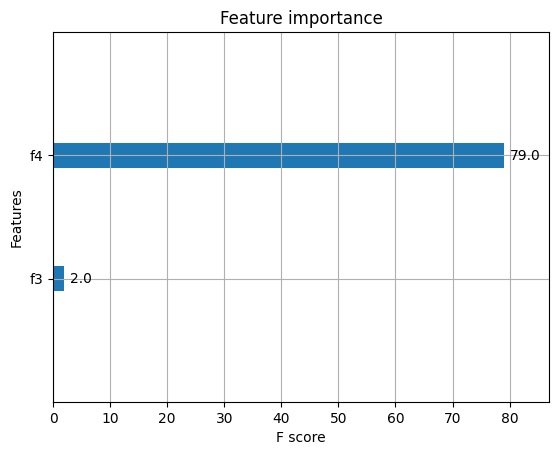

In [108]:
# requires graphviz and python-graphviz conda packages
import graphviz

xgb.plot_importance(xgb_model)

# plot the output tree via matplotlib, specifying the ordinal number of the target tree
# xgb.plot_tree(xgb_model, num_trees=xgb_model.best_iteration)

# converts the target tree to a graphviz instance
xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration)

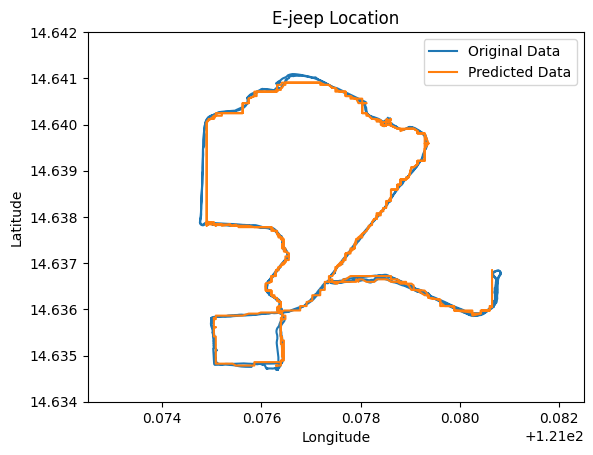

In [97]:
import matplotlib.pyplot as plt

plt.title("E-jeep Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(long_data, lat_data, label="Original Data")
plt.plot(y_pred_long, y_pred_lat, label="Predicted Data")
plt.xlim(121.0725, 121.0825)
plt.ylim(14.634, 14.642)
plt.legend()
plt.show()

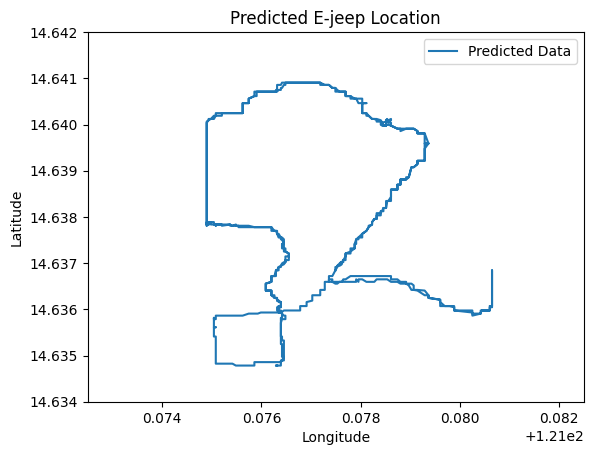

In [86]:
plt.title("Predicted E-jeep Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(y_pred_long, y_pred_lat, label="Predicted Data")
plt.xlim(121.0725, 121.0825)
plt.ylim(14.634, 14.642)
plt.legend()
plt.show()

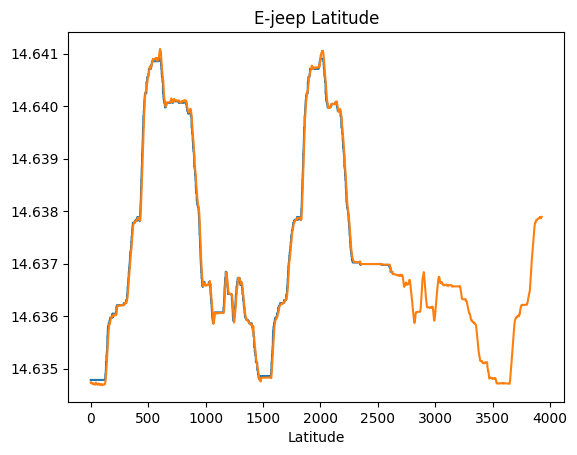

In [99]:
plt.title("E-jeep Latitude")
plt.xlabel("Latitude")
plt.plot(y_pred_lat, label="Predicted Data")
plt.plot(lat_data, label="Original Data")
plt.show()

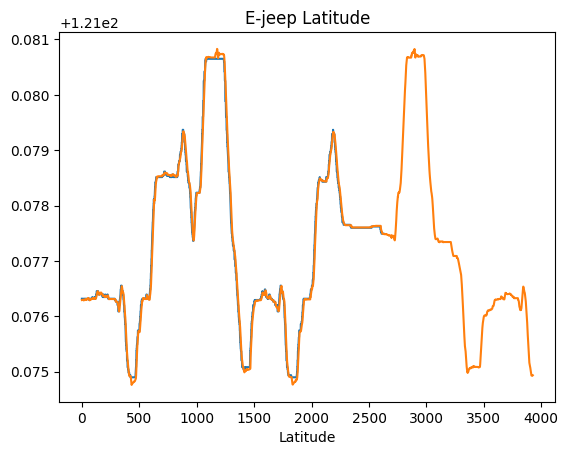

In [100]:
plt.title("E-jeep Latitude")
plt.xlabel("Latitude")
plt.plot(y_pred_long, label="Predicted Data")
plt.plot(long_data, label="Original Data")
plt.show()

In [109]:
from sklearn.metrics import mean_squared_error

lat_rmse = mean_squared_error(lat_data[:len(y_pred_lat)], y_pred_lat, squared=False)
long_rmse = mean_squared_error(long_data[:len(y_pred_long)], y_pred_long, squared=False)

lat_rmse
long_rmse

8.43562534692523e-05

In [110]:
from sklearn.metrics import accuracy_score

lat_acc = accuracy_score(lat_data[:len(y_pred_lat)], y_pred_lat)
lat_acc = accuracy_score(long_data[:len(y_pred_lat)], y_pred_long)

ValueError: continuous is not supported